<a href="https://colab.research.google.com/github/thaCripple/SkinLesion_Classifier_v1/blob/main/SkinLesions_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesions Image Classifier

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn
import torchvision

In [ ]:
!pip install -q torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.5 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import random
import time

# EDA

In [ ]:
TRAIN_METADATA_PATH = Path("/content/drive/MyDrive/skin_lesions_classifier/train_metadata")
TEST_METADATA_PATH = Path("/content/drive/MyDrive/skin_lesions_classifier/test_metadata.csv")

In [ ]:
train_metadata = pd.read_csv(TRAIN_METADATA_PATH, usecols=["image_id", "dx"], dtype={"dx": "category"})
train_metadata.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [ ]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image_id  10015 non-null  object  
 1   dx        10015 non-null  category
dtypes: category(1), object(1)
memory usage: 88.5+ KB


In [ ]:
test_metadata = pd.read_csv(TEST_METADATA_PATH, usecols=["image_id", "dx"], dtype={"dx": "category"})
test_metadata.head()

,image_id,dx
0,ISIC_0034524,nv
1,ISIC_0034525,nv
2,ISIC_0034526,bkl
3,ISIC_0034527,nv
4,ISIC_0034528,nv


In [ ]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image_id  1512 non-null   object  
 1   dx        1512 non-null   category
dtypes: category(1), object(1)
memory usage: 13.8+ KB


In [ ]:
train_metadata['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
test_metadata['dx'].value_counts()

,count
dx,
nv,909
bkl,217
mel,171
bcc,93
df,44
akiec,43
vasc,35


The dataset is quite imbalanced - we will have to apply class weights to the loss function during model training

## Display a Few Random Images

In [ ]:
TEST_IMGS_ROOT = Path("/content/drive/MyDrive/skin_lesions/test")

In [ ]:
test_imgs_paths = TEST_IMGS_ROOT.glob("*/*")
test_imgs_paths = list(test_imgs_paths)

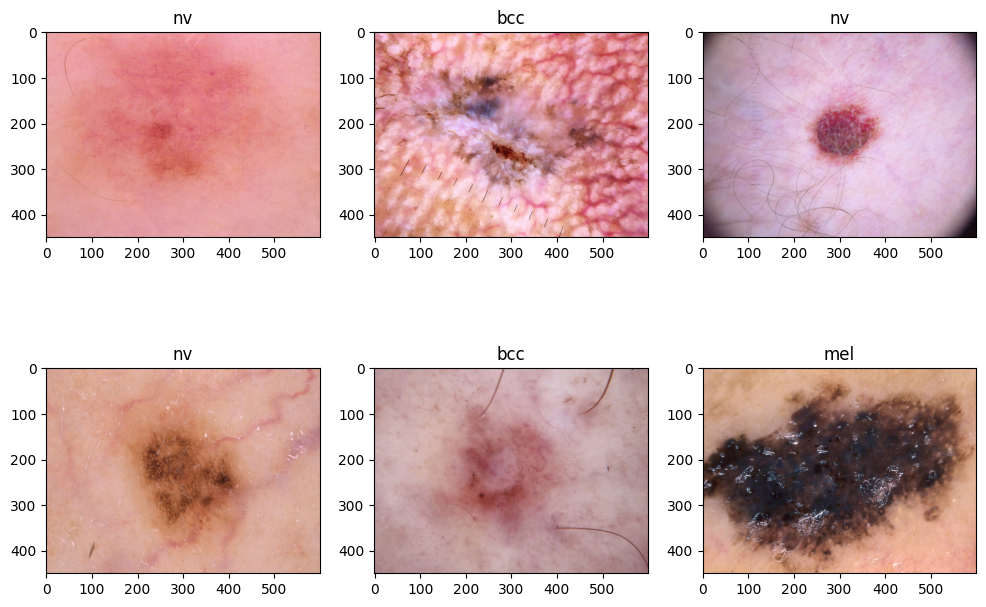

In [ ]:
sample_imgs = random.sample(test_imgs_paths, k=6)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
for i in range(6):
  img = Image.open(sample_imgs[i])
  label = sample_imgs[i].parent.name
  axis = ax.flatten()[i]
  axis.imshow(img)
  axis.set_title(label)

# Importing the Datasets

In [ ]:
TRAIN_IMGS_ROOT = Path("/content/drive/MyDrive/skin_lesions/train")
TRAIN_IMGS_ROOT

PosixPath('/content/drive/MyDrive/skin_lesions/train')

In [ ]:
TEST_IMGS_ROOT

PosixPath('/content/drive/MyDrive/skin_lesions/test')

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
NUM_WORKERS

2

Model's Built-in Transforms

In [ ]:
effnetb0_transforms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
effnetb0_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_ds = torchvision.datasets.ImageFolder(root=TRAIN_IMGS_ROOT, transform=effnetb0_transforms)
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
test_ds = torchvision.datasets.ImageFolder(root=TEST_IMGS_ROOT, transform=effnetb0_transforms)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
print(f"""List of classes: {train_ds.classes}
Class mapping: {train_ds.class_to_idx}""")

List of classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
print(f"""List of classes: {test_ds.classes}
Class mapping: {test_ds.class_to_idx}""")

List of classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


Ok, the class' indicies match-up. I was worried about that

# Instantiate the Base Model

Sadly the free tier of Google Colab couldn't handle EfficientNet_B3.

Let's try EfficientNet_B0.

In [ ]:
effnetb0_model_finetune = torchvision.models.efficientnet_b0(weights="DEFAULT")

In [ ]:
effnetb0_model_finetune

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
effnetb0_model_finetune.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
head_in_features = effnetb0_model_finetune.classifier[-1].in_features
head_in_features

1280

Overwrite the original model's Classification Layer

In [ ]:
effnetb0_model_finetune.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=True)
effnetb0_model_finetune.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
effnetb0_model_finetune = torch.compile(effnetb0_model_finetune.to(device=device, non_blocking=True))

# Define the training functions

## train_step function

In [ ]:
def train_step(model:nn.Module, train_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.train()
  for x_batch, y_batch in train_dl:
    x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    total_epoch_loss += loss.item()

    accuracy = accuracy_fn(preds=logits, target=y_batch)
    total_epoch_accuracy += accuracy.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## test_step function

In [ ]:
def test_step(model:nn.Module, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
              accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)
      total_epoch_loss += loss.item()

      accuracy = accuracy_fn(preds=logits, target=y_batch)
      total_epoch_accuracy += accuracy.item()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## training loop function

In [ ]:
def train_model(model:nn.Module, train_dl:torch.utils.data.DataLoader, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device, epochs:int=1, save_path:Path|None=None)->dict:

  train_metrics = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []}

  for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch}/{epochs-1}")

    train_loss, train_accuracy = train_step(model=model, train_dl=train_dl, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_loss, test_accuracy = test_step(model=model, test_dl=test_dl, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

    train_metrics["train_loss"].append(train_loss)
    train_metrics["train_accuracy"].append(train_accuracy)
    train_metrics["test_loss"].append(test_loss)
    train_metrics["test_accuracy"].append(test_accuracy)

    print(f"Train loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}")
    print(f"Test loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.2f}")
    print("-"*80)

    if save_path is not None:
      torch.save(obj=model, f=save_path)
      print(f"Model saved after epoch {epoch}")

    print(f"Time taken {time.time() - epoch_start_time}s", end="\n\n")

  return train_metrics

# Fine-tune the model

## Define the optimizer and accuracy function

In [ ]:
effnetb0_model_finetune_optimizer = torch.optim.Adam(params=effnetb0_model_finetune.parameters(), lr=5e-5)

In [ ]:
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=7, average="micro").to(device=device, non_blocking=True)

## Define the loss function with class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
y_train = train_metadata['dx'].to_numpy()
len(y_train)

10015

In [ ]:
y_train[:5]

array(['bkl', 'bkl', 'bkl', 'bkl', 'bkl'], dtype=object)

In [ ]:
unique_classes = np.unique(y_train)
unique_classes

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [ ]:
train_ds.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
class_weights_array = compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_train)
class_weights_array

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

In [ ]:
class_weights = torch.from_numpy(class_weights_array).to(device=device, dtype=torch.float32, non_blocking=True)
class_weights

tensor([ 4.3753,  2.7835,  1.3018, 12.4410,  1.2855,  0.2134, 10.0755],
       device='cuda:0')

In [ ]:
effnetb0_model_finetune_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

## Train the model

In [ ]:
effnetb0_model_finetune_epochs = 10

In [ ]:
model_save_path = Path("/content/drive/MyDrive/skin_lesions_classifier") / "effnetb0_model_finetune_training_repeat1_part1.pth"
model_save_path

PosixPath('/content/drive/MyDrive/skin_lesions_classifier/effnetb0_model_finetune_training_part2.pth')

In [ ]:
effnetb0_model_finetune_train_history = train_model(
    model=effnetb0_model_finetune,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=effnetb0_model_finetune_loss_fn,
    optimizer=effnetb0_model_finetune_optimizer,
    accuracy_fn=accuracy_fn,
    device=device,
    epochs=effnetb0_model_finetune_epochs,
    save_path=model_save_path)

Epoch 0/9
Train loss: 0.095 | Train Accuracy: 0.94
Test loss: 0.039 | Test Accuracy: 0.98
--------------------------------------------------------------------------------
Model saved after epoch 0
Time taken 318.7825129032135s
Epoch 1/9
Train loss: 0.098 | Train Accuracy: 0.94
Test loss: 0.094 | Test Accuracy: 0.98
--------------------------------------------------------------------------------
Model saved after epoch 1
Time taken 637.3361721038818s
Epoch 2/9
Train loss: 0.076 | Train Accuracy: 0.95
Test loss: 0.032 | Test Accuracy: 0.99
--------------------------------------------------------------------------------
Model saved after epoch 2
Time taken 953.4120879173279s
Epoch 3/9
Train loss: 0.074 | Train Accuracy: 0.96
Test loss: 0.018 | Test Accuracy: 0.99
--------------------------------------------------------------------------------
Model saved after epoch 3
Time taken 1271.135381937027s
Epoch 4/9
Train loss: 0.067 | Train Accuracy: 0.96
Test loss: 0.021 | Test Accuracy: 0.99
--

# Plot Model Training History

In [ ]:
def plot_history(history_dict:dict)->None:
  x_ticks = np.arange(0, len(history_dict["train_loss"]), 1)

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
  ax[0].plot(x_ticks, history_dict["train_loss"], color="green", label="Train Loss")
  ax[0].plot(x_ticks, history_dict["test_loss"], color="blue", label="Test Loss")
  ax[0].set_xticks(ticks=x_ticks)
  ax[0].legend()

  ax[1].plot(x_ticks, history_dict["train_accuracy"], color="green", label="Train Accuracy")
  ax[1].plot(x_ticks, history_dict["test_accuracy"], color="blue", label="Test Accuracy")
  ax[1].set_xticks(ticks=x_ticks)
  ax[1].legend()

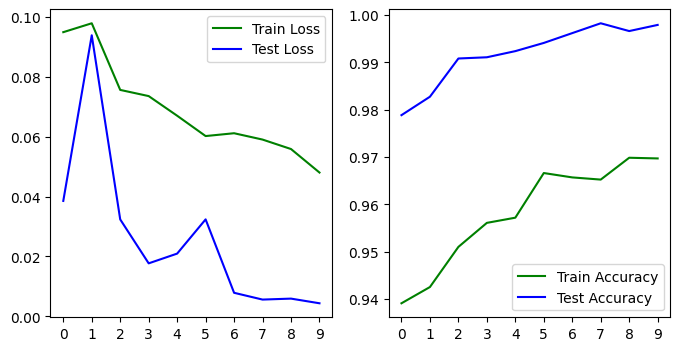

In [ ]:
plot_history(effnetb0_model_finetune_train_history)

# Evaluate the Model's Performance

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
def get_predictions(model:nn.Module, test_dl:torch.utils.data.DataLoader, device:str=device)->torch.Tensor:

  model.eval()
  with torch.inference_mode():
    batched_predictions = []
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

      batch_logits = model(x_batch)
      batch_predictions = torch.argmax(batch_logits, dim=1)
      batched_predictions.append(batch_predictions)
  predictions = torch.cat(batched_predictions, dim=0).to(device="cpu")
  return predictions

In [ ]:
effnetb0_model_finetune_predictions = get_predictions(model=effnetb0_model_finetune, test_dl=test_dl, device=device)
effnetb0_model_finetune_predictions[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_true = test_ds.targets
y_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
y_labels = test_ds.classes
y_labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
print(classification_report(y_true=y_true, y_pred=effnetb0_model_finetune_predictions, target_names=y_labels))

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00        43
         bcc       1.00      1.00      1.00        93
         bkl       1.00      1.00      1.00       217
          df       1.00      1.00      1.00        44
         mel       1.00      1.00      1.00       171
          nv       1.00      1.00      1.00       908
        vasc       1.00      1.00      1.00        35

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



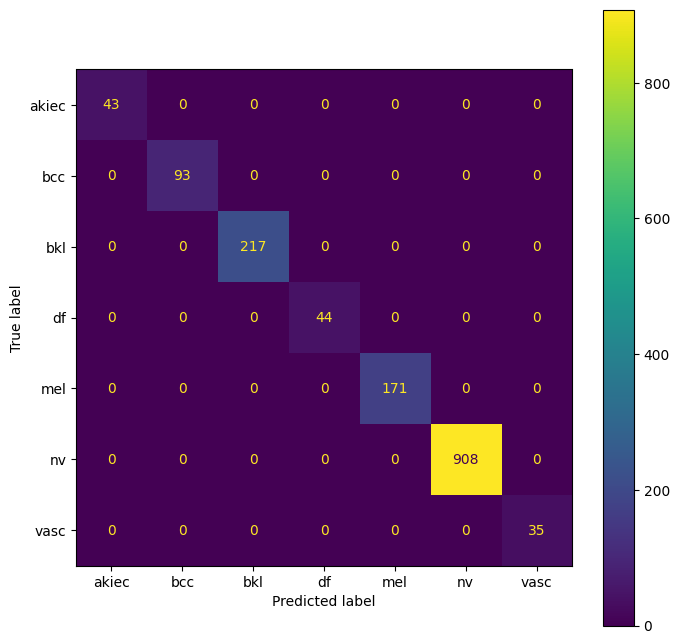

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=effnetb0_model_finetune_predictions, display_labels=y_labels, ax=ax)

# Classify Some New Images

In [ ]:
img1_path = Path("/content/drive/MyDrive/skin_lesions_classifier/my_lesions/benign.jpg")
img1 = Image.open(img1_path)

In [ ]:
img_transformed = torch.unsqueeze(input=effnetb0_transforms(img1), dim=0).to(device=device)
img_transformed.shape

torch.Size([1, 3, 224, 224])

In [ ]:
y_labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
def classify_lesion(img_path):
  raw_img = Image.open(img_path)
  img_transformed = torch.unsqueeze(input=effnetb0_transforms(raw_img), dim=0).to(device=device)

  effnetb0_model_finetune.eval()
  with torch.inference_mode():
    logits = effnetb0_model_finetune(img_transformed)
    prediction = torch.argmax(logits)
  predicted_class = y_labels[prediction]

  fig, ax = plt.subplots()
  ax.imshow(raw_img)
  ax.axis(False)
  ax.set_title(label=predicted_class)

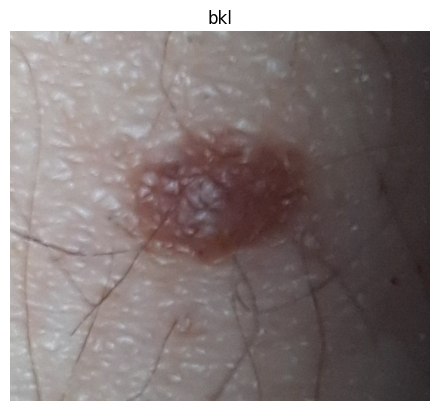

In [ ]:
classify_lesion(img1_path)

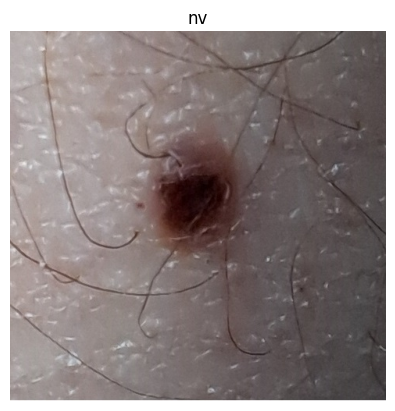

In [ ]:
img2_path = Path("/content/drive/MyDrive/skin_lesions_classifier/my_lesions/suspicious.jpg")
classify_lesion(img2_path)